# **Assignment Layout 📎**

The assignment has been divided into five major sections:

---



1.   **Exploring the Data:** Inspecting our dataset and finding out basic statistics. 

2.   **Design Decisions:** We'll make decisions for questions such as the model architecture to be used, strategy for tokenization, input data framing etc.

3.   **Model Training:** This section will is dedicated to model definition and training.

4.   **Results:** Examples of some of the results of training will be shown here.

5.   **Conclusions:** Final thoughts and future improvements. 

---



In [ ]:
!pip install -q sentencepiece
!pip install -q transformers

import sys
import sentencepiece as spm
import os
import re
import time
import random
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
import pickle

from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tqdm.notebook import tqdm


# repo that enables Atttention Weights visualization
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!pip install transformers

# check GPU version
!nvidia-smi

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## **1. Exploring the Data 👀**

This section covers the following content:

---

*   Samples from the data.
*   Length of the text file.
*   Number of unique characters.
*   Number of unique words.



---



### **Let's look at an excerpt!**

In [ ]:
# load the corpus
corpus = open('/content/shakespeare_input.txt', 'r').read()

# check out some sample excerpts from the corpus
print('*** SAMPLE TEXT FROM CORPUS *** \n')
print(corpus[:1000])
print('*** END OF TEXT FROM CORPUS ***')

*** SAMPLE TEXT FROM CORPUS *** 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for b

### **Calculating some basic statistics, which may come in handy later!**

In [ ]:
# length of the corpus
print('The corpus has {} lines of text with a total character count of {}'.format(len(corpus.split('\n')), len(corpus)))

# unique character count
print('The corpus has {} characters, {} are unqiue.'.format(len(corpus), len(list(set(corpus)))))

# unique word count
print('The corpus has {} words, {} are unique.'.format(len(corpus.split()), len(list(set(corpus.split())))))

The corpus has 167205 lines of text with a total character count of 4573338
The corpus has 4573338 characters, 67 are unqiue.
The corpus has 832301 words, 62983 are unique.


### **Repeating some calculations with some minimal text processing!**

In [ ]:
# some minimal text processing
corpus = corpus.lower()
processed_corpus = re.findall(r"[\w']+|[.,!?;:-]", corpus.lower())

# unique character count
print('The corpus has {} characters, {} are unqiue.'.format(len(corpus), len(list(set(corpus)))))

# unique word count
print('The corpus has {} words, {} are unique.'.format(len(processed_corpus), len(list(set(processed_corpus)))))

The corpus has 4573338 characters, 41 are unqiue.
The corpus has 1039590 words, 25508 are unique.


## **2. Design Decisions 🔧**


This section aims to answer the following questions:

---

*   Character Level or Word Level? 
*   Vocabulary Size?
*   Model Architecture?
*   Input data format?


---







### **Character Level Model vs. Word Level Model**



---




*   Character Level Models are easier and **faster to train** because the vocabulary is very less (67 for this corpus) but at the same time, they have been known to **fail at capturing semantic content between lines of generated text** which is clearly important. 

*   On the other hand, Word Level Models are on the opposite spectrum where they are **harder to train** because of the large vocabulary needed although they **do generate semantically plausable sequences.**

*   Even after having a large vocubulary completely covering the training data, at test time **it may encounter out-of-vocabulary (OOV) words** and end up generating a lot of `<UNK>` tokens.

*   Solution? A hybrid between the two paradigms where uncommon words are **broken up into "subwords".**

*   All major model releases post 2018 features the Subword Level Models like **BERT, GPT-2**, etc.











---




### **Deciding the Vocabulary Size**


---

*   Even with Subword Level Models, we must decide on a vocabulary size where the common words will be stored along with the subwords picked by the subword tokenizer.

*   To find out a good vocabulary size, we can plot frequency of words occuring in the corpus as shown in the first plot. 

*   We can see that are **hardly 500-600 words which have appeared more than 100 times** in the data.

*   We can also plot the **top N frequently occuring words as a percentage of words in the corpus.**

*  **We can see that the top 10K words cover almost 98% of the vocabulary.** So we can choose to go with a vocabulary of 10K words!









---







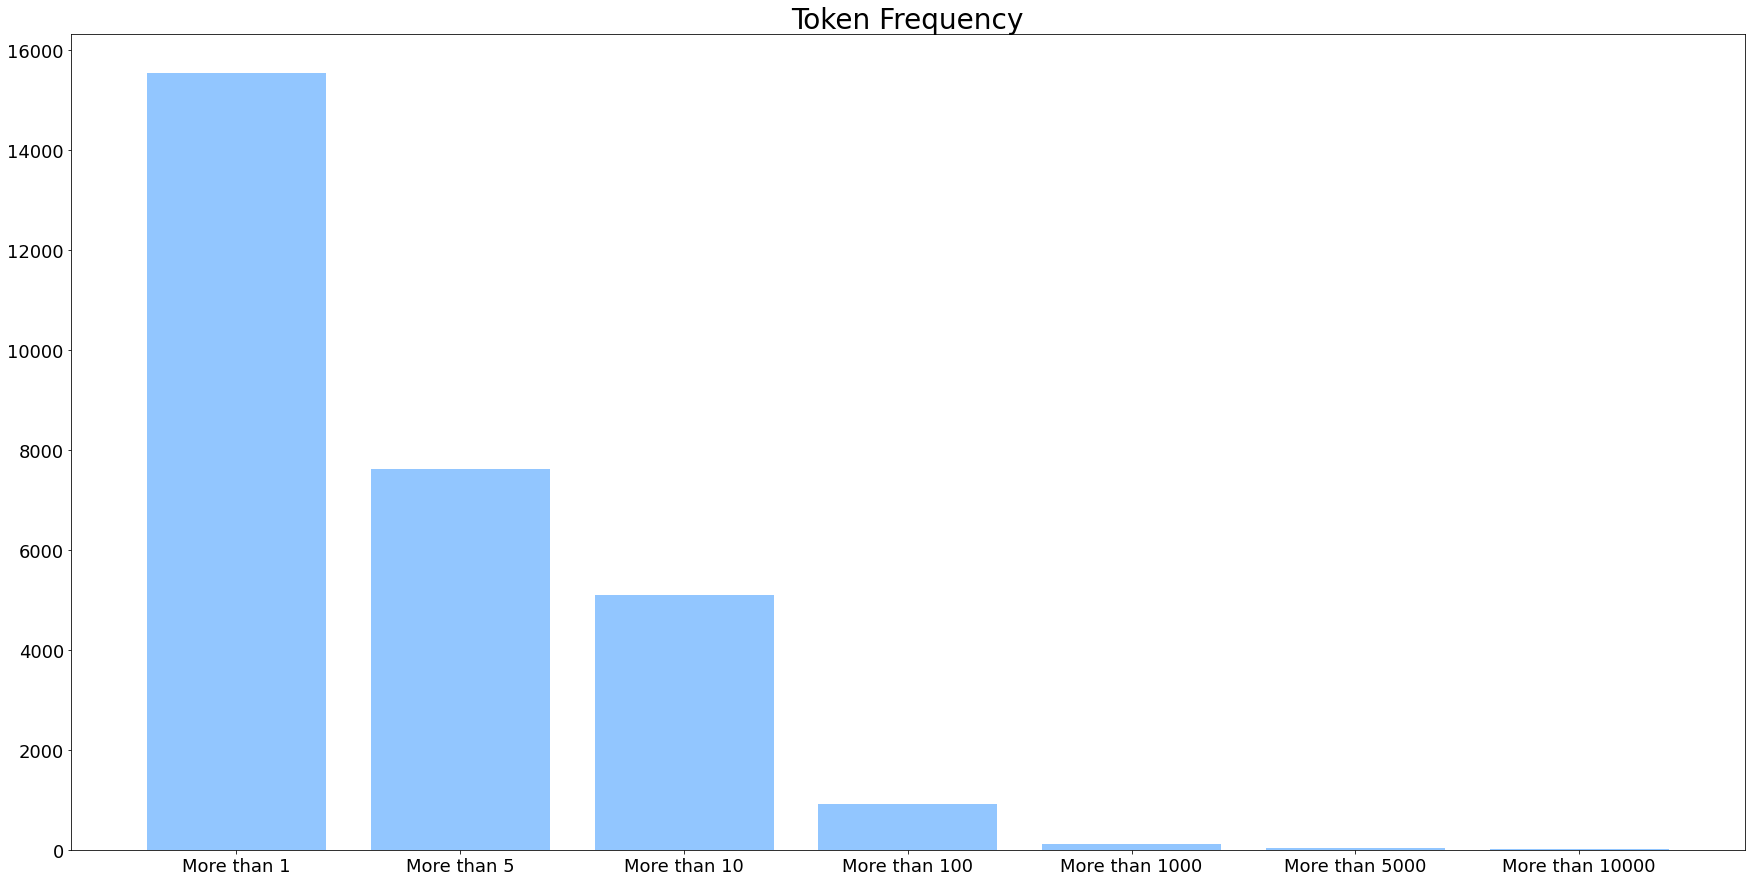

In [ ]:
def tokenize_corpus(processed_corpus):
  tokenizer = Tokenizer(filters='#$%&*+/<=>@^_`{|}~', oov_token= '<UNK>')
  tokenizer.fit_on_texts(processed_corpus)
  return tokenizer

def plot_word_frequency(tokenizer, discrete_freqs_list):
    counts = [sum([1 for value in tokenizer.word_counts.values() if value > freqs]) for freqs in discrete_freqs_list]
    discrete_freqs_dict = {'More than ' + str(freq) :  counts[idx] for idx, freq in enumerate(discrete_freqs_list)}
    plt.style.use('seaborn-pastel')
    plt.figure(figsize=(30, 15))
    plt.title('Token Frequency', fontdict= {'fontsize':28})
    plt.bar(list(discrete_freqs_dict.keys()), list(discrete_freqs_dict.values()))
    plt.tick_params(labelsize=18)
    plt.show()

tokenizer = tokenize_corpus(processed_corpus)
plot_word_frequency(tokenizer, [1, 5, 10, 100, 1000, 5000, 10000])

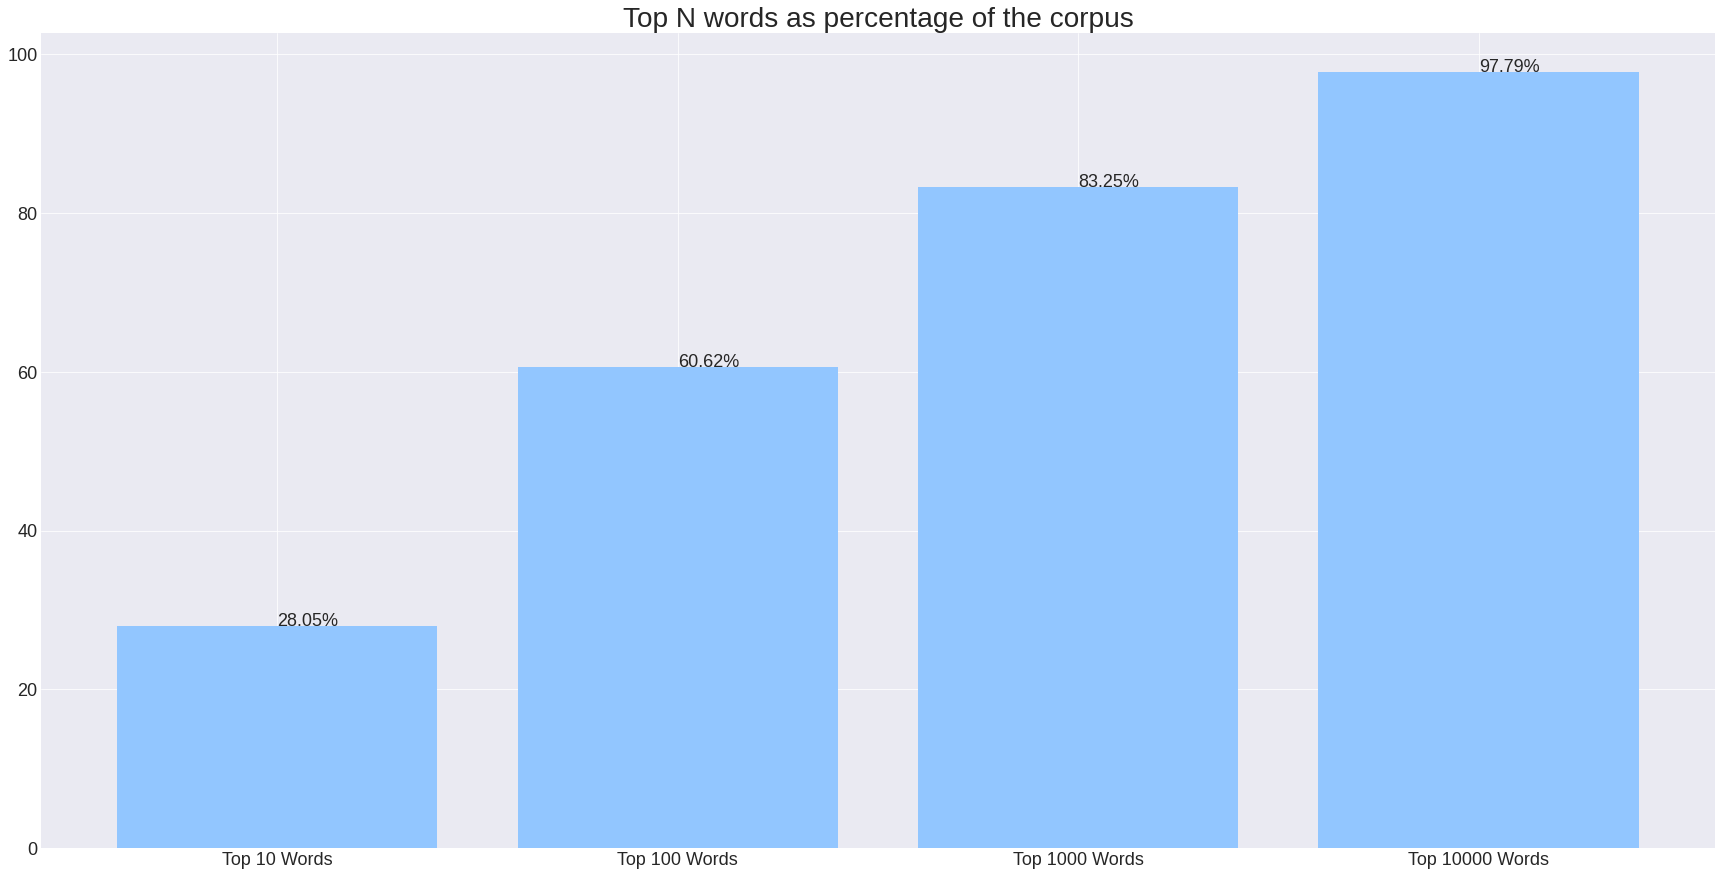

In [ ]:
def plot_top_n_perc(tokenizer, top_n_list):
  total_words = sum([value for value in tokenizer.word_counts.values()])
  top_n_cumm = [sum([value[1] for value in Counter(tokenizer.word_counts).most_common(top_n)]) * 100 / total_words for top_n in top_n_list]
  to_plot = {'Top {} Words'.format(top_n) :  top_n_cumm[idx] for idx, top_n in enumerate(top_n_list)}

  plt.style.use('seaborn-darkgrid')
  plt.figure(figsize=(30, 15))
  plt.title('Top N words as percentage of the corpus', fontdict= {'fontsize':28})
  plt.bar(list(to_plot.keys()), list(to_plot.values()))
  plt.tick_params(labelsize=18)
  plt_round = [round(value, 2) for value in list(to_plot.values())]
  for i in range(len(to_plot)):
    plt.annotate(str(plt_round[i]) + '%', xy=(list(to_plot.keys())[i], list(to_plot.values())[i]), size=18)
  plt.show()

plot_top_n_perc(tokenizer, top_n_list = [10, 100, 1000, 10000])

In [ ]:
# subword tokenization on the corpus
spm.SentencePieceTrainer.train(input='/content/shakespeare_input.txt', model_prefix='shakepeare', vocab_size=10000, user_defined_symbols=['\n'])

# Load model
sp = spm.SentencePieceProcessor(model_file='/content/shakepeare.model')

# Load corpus
corpus = open('/content/shakespeare_input.txt', 'r').read()

# Encode the corpus
encoded_corpus = sp.encode(corpus)

In [ ]:
# verify that the tokenization works
print("*** A SAMPLE FROM THE CORPUS YET AGAIN ***")
print()
print(sp.decode(encoded_corpus[:100]))

*** A SAMPLE FROM THE CORPUS YET AGAIN ***

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.



### **Model Architecture**

---

Having decided on a subword model, we now have to decide our model architecture. 

Out of the many possibilies, few good choices are:


*   An `Embedding` layer followed by `RNN /LSTM /GRU /BiLSTM` layer(s) followed by a `Dense` layer.
(`Embedding` -> `RNN /LSTM /GRU /BiLSTM` -> `Dense`)

*   An `Encoder` and `Decoder` architecture with or without `Attention` (`Encoder` -> `{Attention Layer}` -> `Decoder`) also called `seq2seq` model. 

*   A `Transformer` Architecture (no sequential layers) with `Self-Attention` and trained with a LM objective (auto-regressive). 

We will explore the **second and third options since they give us a way to interpret the model (Attention).**

---









### **Input Data**



---
There are many ways to process our input. Some of them are:

*   **A (`one-token`, `next-token`) tuple ->** Not a good choice as it does not take into account any context of previous tokens. 

*   **A (`sequence-of-tokens`, `next-token-in-that-sequence`) tuple ->** A common choice but it drastically increases the training data size.

*   **A (`sequence-of-tokens`, `continuation-of-that-sequence`) tuple->** A resonable choice here since it keeps the resulting data size small.

**We also need to create generators and load the data in batches so as to not overshoot the RAM limit.**

---







In [ ]:
# generators for batch loading
def get_batch(corpus, batch_sz, enc_length, dec_length, **kwargs):

  subset = kwargs['subset']
  for_model = kwargs['for_model']
  train_split = kwargs['train_split']
  overlap = kwargs['overlap']

  chunk = (batch_sz * overlap)
  train_batches = math.floor((len(corpus) // (chunk)) * train_split)
  total_batches = math.floor((len(corpus) // (chunk)))

  if subset == 'train':
    for batch in range(0, train_batches * chunk, chunk):
      x_batch = [corpus[batch + (overlap * i) : batch + (overlap * i) + enc_length] for i in range(batch_sz)]
      y_batch = [corpus[batch + (overlap * i) + enc_length : batch + (overlap * i) + enc_length + dec_length] for i in range(batch_sz)]

      if for_model == 'transformer':
        yield x_batch, y_batch
      if for_model == 'seq2seq':
        yield np.array(x_batch), np.array(y_batch)
  
  if subset == 'val':
    for batch in range(0, train_batches * chunk, chunk):
      x_batch = [corpus[batch + (overlap * i) : batch + (overlap * i) + enc_length] for i in range(batch_sz)]
      y_batch = [corpus[batch + (overlap * i) + enc_length : batch + (overlap * i) + enc_length + dec_length] for i in range(batch_sz)]

      if for_model == 'transformer':
        yield x_batch, y_batch
      if for_model == 'seq2seq':
        yield np.array(x_batch), np.array(y_batch)

In [ ]:
# sample example
batch_sz = 128
enc_length = 50
dec_length = 50
overlap = 25
train_split = 0.8

# load the generator
dataloader = get_batch(encoded_corpus, batch_sz, enc_length, dec_length, overlap = overlap, train_split = train_split, subset = 'train', for_model = 'seq2seq')

# get a batch from training data
x_batch, y_batch = next(dataloader)

# print an example of the data
example_num = 0
print('### Input ### \n {} \n'.format(sp.decode(x_batch[example_num].tolist())))
print('### Output ### \n {}'.format(sp.decode(y_batch[example_num].tolist())))

### Input ### 
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All: 

### Output ### 
 
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.



## **3. Model Training 🚀** 

After framing the input data

---

A `seq2seq` model with Attention covering the following components:

*   Encoder 
*   Bahdanau Attention
*   Decoder
*   Training Procedure

A `Transformer` architecture covering the following components:

*   Loading the pre-trained model
*   Fine-tuning on this specific downstream task


---









### **Encoder**

---
The `Encoder` action is as follows:

1.   The encoder takes in a batch of sequences (tokenized and encoded) and performs forward pass on it. 

2.   We set `return_sequences` and `return_state` both to `True` because for `Attention` we'll need access to `Encoder` states for all words that it saw.

---








In [ ]:
# define encoder variables
vocab_size = 10000
embedding_dim = 256
enc_units = 512

# define encoder
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.dropout = Dropout(0.1)
    self.gru = GRU(self.enc_units,
               return_sequences=True,
               return_state=True,
               recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    x = self.dropout(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
# call the Encoder 
encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x_batch, sample_hidden)
print ('Encoder Output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Output shape: (batch size, sequence length, units) (128, 50, 512)
Encoder Hidden state shape: (batch size, units) (128, 512)


### **Bahdanau Attention**

---

The `Attention` layer implemented is the **Bahdanau Attention** introduced in 2014 by **Dr. Dzmitry Bahdanau** et. al.

The basic concept is to use the `Encoder`'s output states for each word/token in the input sentence along with the `Decoder`'s hidden states for the current timestep to have a "narrower" focus of **which words in the sequences to "attend to"** for the next word prediction. 



Here are the equations that are implemented:


<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

The original paper can be found here [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf). 


---


Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = `Encoder` output
* H = hidden state
* X = input to the `Decoder`

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`

* `attention weights = softmax(score, axis = 1)`. 

* `context vector = sum(attention weights * EO, axis = 1)`. 

* `embedding output` = The input to the `Decoder` X is passed through an embedding layer.

* `merged vector = concat(embedding output, context vector)`

* This merged vector is then given to the `Decoder GRU`


---




In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
# sample input
attention_layer = BahdanauAttention(20)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 512)
Attention weights shape: (batch_size, sequence_length, 1) (128, 50, 1)


### **Decoder**

---


1.   During training, the decoder first calculates the context vector which is then passed to the next timestep of the `Decoder` along with the current input (teacher forcing).

2.   During inference, we use the `Decoder`'s own output as the input to the next step along with the context vector

3.   In both the cases, the context vector is calculated by the hidden states of the `Encoder` and the hidden state of the `Decoder` at timestep $$(t-1). 


---








In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.dropout = Dropout(0.1)
    self.gru = GRU(self.dec_units,
                   return_sequences=True,
                   dropout = 0.1,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # use dropout
    x = self.dropout(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
# define decoder variables
vocab_size = 10000
embedding_dim = 256
dec_units = 512

decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_sz, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 10000)


### **Training Procedure**



---

The training procedure followed is outline below:

1. Pass the *input* through the `Encoder` which will return the `Encoder` *output* and the *hidden state*.

2. The `Encoder` output, `Encoder` hidden state and the decoder input (which is the *start token*) is passed to the `Decoder`.

3. The `Decoder` returns the *predictions* and the `Decoder` *hidden state*.

4. The `Decoder` hidden state is then passed back into the model and the predictions are used to calculate the loss.

5. Use *teacher forcing* to decide the next input to the `Decoder`.

6. **Teacher forcing** is the technique where the **target word** is passed as the **next input** to the `Decoder`. 

7. This is done so that the `Decoder` sequence **does not diverge early on during training** and hence result in a huge loss making it difficult to coverge. 

8. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


---




In [ ]:
# optimizers and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):

  # takes care of [PAD] tokens (0) and computes loss
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):

  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims(inp[:, -1], 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(0, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
def evaluate(sentence, length):

  # temperature
  temperature = 0.8

  # setup attention plots
  max_length_targ = length
  max_length_inp = sentence.shape[1]

  # store attention weights to plot later on
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # store value of sentence tensor in a variable
  inputs = tf.convert_to_tensor(sentence)

  # decode sentence tensor to text
  sentence = sp.decode(sentence.numpy().tolist()[0])

  result = ''

  hidden = [tf.zeros((1, 512))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims(tf.expand_dims(inputs[0][-1], 0), 1)

  loss = 0

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

 
    # using a temperature with topk sampling distribution to decode
    predictions = predictions / temperature
    #predictions_topk = tf.math.top_k(predictions, k=5, sorted=True)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

    #predicted_id = tf.argmax(predictions[0]).numpy()

    result += sp.id_to_piece(int(predicted_id))

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)


  # replace tokenized spaces in result
  underscore = sp.id_to_piece(sp.encode('This'))[0][0]
  result = result.replace(underscore, ' ')
  return result, sentence, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def translate(x_val_batch, length):

  # select a random index from the batch
  index = random.randint(0, x_val_batch.shape[0]-1)

  # get a sentence
  sentence = tf.expand_dims(x_val_batch[index], 0)

  result, sentence, attention_plot = evaluate(sentence, length)

  print('### Input ### \n {}'.format(sp.decode(sentence)))
  print()
  print('### Generated ### \n {}'.format(result))

  attention_plot = attention_plot[:len(result.split()), :len(sentence.split())]

  plot_attention(attention_plot, sentence.split(), result.split())

In [ ]:
checkpoint_dir = '/content/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 100
val_dataloader = get_batch(encoded_corpus, batch_sz, enc_length, dec_length, overlap = overlap, train_split = train_split, subset = 'val', for_model = 'seq2seq')

for epoch in range(EPOCHS):

  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # load the train and validation generators
  train_dataloader = get_batch(encoded_corpus, batch_sz, enc_length, dec_length, overlap = overlap, train_split = train_split, subset = 'train', for_model = 'seq2seq')

  for (batch, (x_batch, y_batch)) in enumerate(tqdm(train_dataloader)):
    batch_loss = train_step(x_batch, y_batch, enc_hidden)
    total_loss += batch_loss

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # evaluate samples after each epoch
  x_val_batch, _ = next(val_dataloader)
  translate(x_val_batch, 100)  

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / batch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Output hidden; open in https://colab.research.google.com to view.

### Input ### 
 
Then, window, let day in, and let life out.

ROMEO:
Farewell, farewell! one kiss, and I'll descend.

JULIET:
Art thou gone so? love,

### Generated ### 
  sir?

CLAUDIO:
Why, but, methinks she will to the laws of mine authority, for I am meek
Which, but is now:
Be not a notorious pirate;
That I was a fool indeed;
Whom for my soul;
Beingdrian, my lord, will he be a little life I love you, if he were
That I have no more gift?

SEBASTIAN:
No general


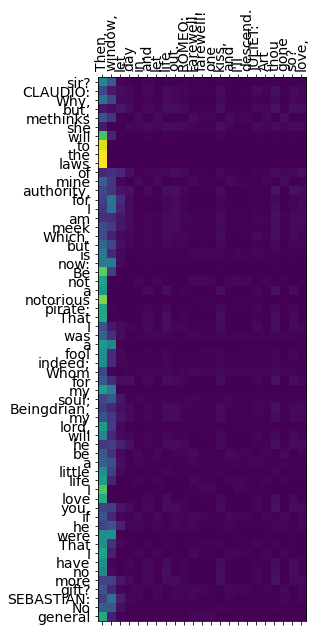

In [ ]:
x_val_batch, _ = next(val_dataloader)
translate(x_val_batch, 100)  

### **Training with a Transformer Architecture**


---

In this section we will use a `Transformer` model to train on the same dataset. 

We'll use the GPT-2 model made available by the [huggingface](https://https://huggingface.co/transformers/philosophy.html) library. 


**(Note: These code cells have not been run in Colab because the model has already been trained on Kaggle)**

---




In [ ]:
# load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# add tokens to tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# load model
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)
model.resize_token_embeddings(len(tokenizer))

# load corpus
corpus = open('/kaggle/input/assignment7/shakespeare_input.txt', 'r').read()

In [ ]:
# define parameters
batch_sz = 8
enc_length = 300
dec_length = 300
overlap = 100
train_split = 0.8
EPOCHS = 2
LEARNING_RATE = 3e-4


# call the generator function to load generators
train_loader = get_batch(corpus, batch_sz, enc_length, dec_length, overlap = overlap, train_split = train_split, subset = 'train', for_model = 'transformer')
val_dataloader = get_batch(corpus, batch_sz, enc_length, dec_length, overlap = overlap, train_split = train_split, subset = 'val', for_model = 'transformer')


In [ ]:
# fine-tune the model
model.cuda()
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):

  for (batch, (x_batch, y_batch)) in enumerate(tqdm(dataloader)):

    inputs = tokenizer(x_batch, y_batch, return_tensors="pt", padding=True, return_token_type_ids=True)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    
    outputs = model(**inputs, labels=inputs["input_ids"])
        
    loss, logits = outputs[:2]                        
    loss.backward()

    sum_loss = loss.detach().data
                       
    optimizer.step()
    optimizer.zero_grad()
    model.zero_grad()
            
    if batch % 2000 == 0:
      x_val_batch, _ = next(val_dataloader)
      index = random.randint(0, len(x_val_batch) - 1)
      val_inputs = tokenizer(x_val_batch[index], return_tensors="pt", padding=True, return_token_type_ids=True)
      val_inputs = {k: v.cuda() for k, v in val_inputs.items()}
      model.eval()
      print(f"sum loss {sum_loss}")
      sample_outputs = model.generate(input_ids = val_inputs["input_ids"],
                                      attention_mask = val_inputs["attention_mask"],
                                    do_sample=True, 
                                    temperature = 0.8,  
                                    max_length = 300,
                                    num_return_sequences=1
                                )

      print("Output:\n" + 100 * '-')
      torch.save(model.state_dict(), '/kaggle/working/epoch_{}_batchnum_{}.pt'.format(epoch+2, batch))
      for i, sample_output in enumerate(sample_outputs):
        print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
      model.train()

## **4. Results 🤖**

This section covers the following content:



---

*   Generated Text
*   Model Interpretability


---









### **Results with `seq2seq x Bahdanau Attention`**

### Input ### 
 am I mad, hearing him talk of Juliet,
To think it was so? O, give me thy hand,
One writ with me in sour misfortune's book!
I'll bury thee in a triumphant grave;
A

### Generated ### 
 bate his bed,
Stepin the people 'twixt twelve and not well.
But that I, lords,
I have begun to make themselves,
Why, I told you, the poor son Lucentio.

BAPTISTA:
Yet thou shalt hear.

PETRUCHIO:
I do begin.

ANTONIO:
They have more helpful bosom.
Therefore they feed
'By as my integrity: if I do me a rusic, but be as a thief,
Whom you'll stalls,
Unless you more
Great moons, my sweet wench:
I'll be of a glass.

KATHARINA:
BHORSA:
Now, my master constable?

ALONSO:
Sir, and, he knows, and then.

PROSPERO:
Pray you


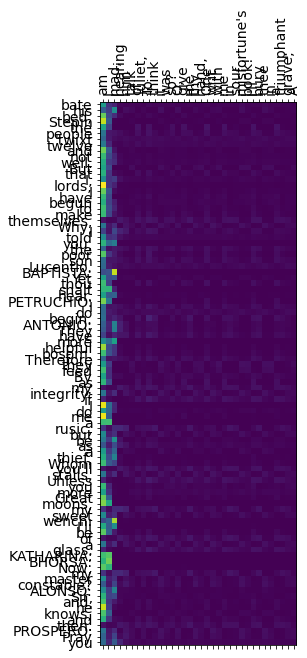

In [ ]:
x_val_batch, _ = next(val_dataloader)
translate(x_val_batch, 200)  

### **Results with `Transformer x GPT-2`**

In [ ]:
# enables attention weights visualization
# https://github.com/jessevig/bertviz
from bertviz import head_view

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
# mount drive to load checkpoint model
from google.colab import drive
drive.mount('/content/drive')

# load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# add tokens to tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# load model
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)
model.resize_token_embeddings(len(tokenizer))
model.cuda()


# load model from checkpoint and predict
model.load_state_dict(torch.load('/content/drive/My Drive/epoch_1_batchnum_4000.pt'))


inputs = tokenizer(sp.decode(x_val_batch[0].tolist()), return_tensors="pt", padding=True, return_token_type_ids=True)
inputs = {k: v.cuda() for k, v in inputs.items()}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.eval()
sample_outputs = model.generate(input_ids = inputs["input_ids"],
                                      attention_mask = inputs["attention_mask"],
                                    do_sample=True, 
                                    temperature = 0.8,  
                                    max_length = 300,
                                    num_return_sequences=1
                                )
for i, sample_output in enumerate(sample_outputs):
        print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0: ing gear
As will disperse itself through all the veins
That the life-weary taker may fall dead
And that the trunk may be discharged of breath
As violently as hasty powder fired
Doth hurry in the blood; for the enemy
Hath sent them down the wrong direction of such a battle,
Of such a general and such a soldier
As I am.

MOTHELLO:
That's the least of my shame:
I have slain the very enemy,
Whose great sword and that handkerchief I gave him.

KING HENRY IV:
But now he must return in a moment,
To hear of the battle.

MOTHELLO:
Farewell, madam.

KING HENRY IV:
My son, Sir Thomas, you shall see him here,
At supper.

MOTHELLO:
I'll to-morrow, madam. By the way, sirrah;
You shall hear more by the way.

KING HENRY IV:
What, dost thou hear of the fight?

MOTHELLO:
I will hear more; for he is slain there,
And 


In [ ]:
attention = model(**inputs)[-1]
input_id_list = inputs['input_ids'][0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
head_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

## **5. Conclusions ⚖️**

--- 

*   The `seq2seq` model had to first understand the structure, learn the words, syntax and then produce coherent text. 

*   The `Transformer` model, armed with it's pretraining on heavy corpuses already has a great understanding of the language we are trying to model and as a result does really well with hardly any training. 

*   One of the biggest insights, is that any text generation problem should always start with a pre-training unsupervisied objective so that the model has a really strong understanding of the very language it is trying to generate. 

*   Consequently, the conclusion is that preceding modelling with some pre-training objective would have resulted in better results since here the model **has to learn the language, syntax, semantics and generation**. But with **pre-training, the model only would have to learn the generation part**


---

